Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)
[Li-Yi Wei](http://www.liyiwei.org)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 13 - Parallelizing Neural Network Training with Theano

We have seen how to write a multi-layer perceptron from scratch.

We can also just use existing libraries.
* Theano, Torch, TensorFlow, Caffe, etc.

Advantages of Theano
* Python interface
* Platform support
* GPU support for performance

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,matplotlib,theano,keras

Using Theano backend.


last updated: 2016-10-10 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
matplotlib 1.5.1
theano 0.8.2
keras 1.1.0


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Building, compiling, and running expressions with Theano](#Building,-compiling,-and-running-expressions-with-Theano)
  - [What is Theano?](#What-is-Theano?)
  - [First steps with Theano](#First-steps-with-Theano)
  - [Configuring Theano](#Configuring-Theano)
  - [Working with array structures](#Working-with-array-structures)
  - [Wrapping things up – a linear regression example](#Wrapping-things-up:-A--linear-regression-example)
- [Choosing activation functions for feedforward neural networks](#Choosing-activation-functions-for-feedforward-neural-networks)
  - [Logistic function recap](#Logistic-function-recap)
  - [Estimating probabilities in multi-class classification via the softmax function](#Estimating-probabilities-in-multi-class-classification-via-the-softmax-function)
  - [Broadening the output spectrum by using a hyperbolic tangent](#Broadening-the-output-spectrum-by-using-a-hyperbolic-tangent)
- [Training neural networks efficiently using Keras](#Training-neural-networks-efficiently-using-Keras)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

%matplotlib inline

# Building, compiling, and running expressions with Theano

Developed by the LISA lab lead by Joshua Bengio started in 2008.

Harness multi/many-core CPU/GPU without the burden of 
* parallel computing code
* memory management across processors

<img src='./images/13_01.png' width=80%>

## What is Theano?

A machine learning library with interface in Python.
* with more speed/memory optimization

Focus on tensors as the core data structure.

Tensors are multi-dimensional arrays.
* rank 0 for scalars
* rank 1 for vectors
* rank 2 for matrices

Symbolic manipulation
* build computation graphs
* automatic and symbolic differentiation
* send compiled expressions/graphs to CPU/GPU for execution

## First steps with Theano

http://deeplearning.net/software/theano/introduction.html

Depending on your system setup, it is typically sufficient to install Theano via

    pip install Theano
    
For more help with the installation, please see: http://deeplearning.net/software/theano/install.html

Introducing the TensorType variables. For a complete list, see http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors

In [3]:
import theano
from theano import tensor as T
import numpy as np

In [4]:
# define expression
# which can be visualized as a graph
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# compile
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# execute
answer = net_input(2.0, 1.0, 0.5)
print(answer)
answer

2.5


array(2.5, dtype=float32)

In [5]:
# define
b = T.scalar('b')
x = T.vector('x')
W = T.matrix('W')

y = x.dot(W.transpose())
z = W.dot(x) + b

# similar to python function
# theano function can return multiple outputs
f = theano.function(inputs = [x, W, b], outputs = [y, z])

output_y, output_z = f([1, 2], [[3, 4], [5, 6]], 1)
# output_y, output_z = f([[1, 2]], [[3, 4]], 1) # won't work as x is a vector not matrix
# output_y, output_z = f([1, 2], [3, 4], 1) # won't work as W is a matrix not vector
# output_y, output_z = f([1, 2], [[3, 4]], [1]) # won't work as b is a scalar not a vector/matrix

print(output_y)
print(output_z)

[ 11.  17.]
[ 12.  18.]


Steps for using Theano:
* define symbols and functions
* compile the code
* execute the code

Each variable has a specific type (dtype)
* trade-off between accuracy and cost (speed and storage)
* we have to choose; good for control, bad as burden

## Configuring Theano

Processors:
- Modern CPUs support 64-bit memory address.
- GPUs (and old CPUs) remain in 32-bit.

Theano supports both 32 and 64 bits.

We can configure Theano to use either: float32 (for 32-bit processors) or float64 (for 64-bit processors).

For more options, see
- http://deeplearning.net/software/theano/library/config.html
- http://deeplearning.net/software/theano/library/floatX.html

In [6]:
# default configuration
print(theano.config.floatX)

float32


In [7]:
# we can change it like this
theano.config.floatX = 'float32'

In [8]:
print(theano.config.floatX)

float32


To change the float type globally, execute 

    export THEANO_FLAGS=floatX=float32 
    
in your bash shell. Or execute Python script as

    THEANO_FLAGS=floatX=float32 python your_script.py

Running Theano on GPU(s). For prerequisites, please see: http://deeplearning.net/software/theano/tutorial/using_gpu.html

Note that `float32` is recommended for GPUs; `float64` on GPUs is currently still relatively slow.

In [9]:
print(theano.config.device)

cpu


You can run a Python script on CPU (e.g. for prototyping and debug) via:

    THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py

or GPU (e.g. for real computation) via:

    THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py

It may also be convenient to create a `.theanorc` file in your home directory to make those configurations permanent. For example, to always use `float32`, execute

    echo -e "\n[global]\nfloatX=float32\n" >> ~/.theanorc
    
Or, create a `.theanorc` file manually with the following contents

    [global]
    floatX = float32
    device = gpu


## Working with array structures

This is an example code to work with tensors.

Create a $2 \times 3$ tensor, and calculate its column sum.

In [10]:
import numpy as np

# define
# if you are running Theano on 64 bit mode, 
# you need to use dmatrix instead of fmatrix
x = T.matrix(name='x') # tensor with arbitrary shape
x_sum = T.sum(x, axis=0)

# compile
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# execute (Python list)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

# execute (NumPy array)
ary = np.array(ary, dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


In [11]:
# name can help debug
y = T.matrix(name='hello')
z = T.matrix()

print(y) # will print out variable name
print(z) # will print out variable type
print(y.type()) # will print out type


hello
<TensorType(float32, matrix)>
<TensorType(float32, matrix)>


In [12]:
# explicit type specification
wf = T.fmatrix(name='wfmatrix')
wd = T.dmatrix(name='wdmatrix')

print(wf.type())
print(wd.type())

<TensorType(float32, matrix)>
<TensorType(float64, matrix)>


## Memory management

### shared 

Variable with storage that is shared between functions that it appears in. 
* can have initial or constant values, e.g. weights of a neural network
* retain value across function calls
* cannot be used as input to a function
* can be updated after each function call

Can be more efficient than input variable
* update in place instead of transferring around
* Theano can then optimize the storage across CPUs and GPUs

More info about memory management in Theano can be found under:
* http://deeplearning.net/software/theano/tutorial/aliasing.html
* https://www.quora.com/What-is-the-meaning-and-benefit-of-shared-variables-in-Theano


In [13]:
# initialize
x = T.matrix(name='x')
b = theano.shared(np.asarray([[1]], dtype=theano.config.floatX), name='b')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], 
                             dtype=theano.config.floatX))

# w = w + 1.0 # this will cause error
z = x.dot(w.T) + b

update = [[w, w + 1.0]] # update w after each function call

# compile
f = theano.function(inputs=[x],
                    updates=update,
                    outputs=z)

# won't compile as shared variable cannot be used as input
# g = theano.function(inputs=[x, b], outputs = z)

# execute
x_data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, f(x_data))


z0: [[ 1.]]
z1: [[ 7.]]
z2: [[ 13.]]
z3: [[ 19.]]
z4: [[ 25.]]


### given

input: transfer from CPU to GPU multiple times
* e.g. multiple epochs

shared: retained values across functions, can be updated after each function call
* like static function variables
* not input for function call
* e.g. network weights

given: transfer from CPU to GPU once
* like constant variables
* shared between multiple function calls
* not input for function call
* values specified, for input or shared variables, during funcion compilation 
* e.g. a mini-batch


If we use `inputs`, a datasets is transferred from the CPU to the GPU multiple times, for example, if we iterate over a dataset multiple times (epochs) during gradient descent. 

We can use the `givens` variable to insert values into the graph before compiling it. Using this approach we can reduce the number of transfers from RAM (via CPUs) to GPUs to speed up learning with shared variables. 

Via `givens`, we can keep the dataset on the GPU if it fits (e.g., a mini-batch). 

In [14]:
# define
num_samples = 10
samples = np.asarray([i for i in range(num_samples)],
                     dtype=theano.config.floatX)

# samples = theano.shared(samples)

x = T.lscalar(name='index')
#y = theano.shared(np.asscalar(np.array([1], dtype=theano.config.floatX)))
y = T.vector(name='samples')
w = theano.shared(np.asscalar(np.array([0], dtype=theano.config.floatX)))

z = y[x]*w

# compile
f = theano.function(inputs = [x],
                    updates = [[w, w+1]],
                    givens = {y: samples},
                    outputs = z)

# run
for i in range(np.prod(samples.shape)):
    print(f(i))

0.0
1.0
4.0
9.0
16.0
25.0
36.0
49.0
64.0
81.0


In [15]:
# initialize
x_data = np.array([[1, 2, 3]], dtype=theano.config.floatX)

x = T.matrix(name='hi')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))

# an input variable can be given
b_data = np.array([[-1, 0, 1]], dtype=theano.config.floatX)
b = T.matrix(name='bias')

# a shared variable can be given
c_data = np.array([[4, 5, 6]], dtype=theano.config.floatX)
c = theano.shared(np.asarray([[0]], dtype=theano.config.floatX))

z = x.dot(w.T) + b + c

updates = [[w, w + 1.0]]
givens = {b: b_data, c: c_data}

# compile
net_input = theano.function(inputs=[x], 
                            updates=updates, 
                            givens=givens,
                            outputs=z)

# execute
for i in range(5):
    print('z:', net_input(x_data))

z: [[ 3.  5.  7.]]
z: [[  9.  11.  13.]]
z: [[ 15.  17.  19.]]
z: [[ 21.  23.  25.]]
z: [[ 27.  29.  31.]]


## Wrapping things up: A  linear regression example

Model:
$
y = \sum_{i=0}^n w_i x_i = \mathbf{w}^T \mathbf{x}
$
with $x_0 = 1$.

Given a collection of sample data $\{\mathbf{x^{(i)}}, y^{(i)} \}$, find the line $\mathbf{w}$ that minimizes the regression error:
$$
\begin{align}
L(X, Y, \mathbf{w}) 
= \sum_i \left( y^{(i)} - \hat{y}^{(i)} \right)^2 
= \sum_i \left( y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)} \right)^2
\end{align}
$$


### 2D case

$
y = w_0 + w_1 x
$

<img src='./images/10_01.png' width=90%> 

### Create some training data

In [16]:
import numpy as np
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0],
                      [5.0], [6.0], [7.0], [8.0], [9.0]], 
                     dtype=theano.config.floatX)

y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 
                      6.3, 6.6, 7.4, 8.0, 9.0], 
                     dtype=theano.config.floatX)

### Implement the training function

Notice:
* the symbolic differentiation for the gradient part
* how different variable types (input, shared, givens, output) are used

In [17]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):

    costs = []
    # Initialize arrays
    eta0 = T.scalar('eta0') # learning rate
    y = T.vector(name='y') 
    X = T.matrix(name='X')   
    w = theano.shared(np.zeros(
                      shape=(X_train.shape[1] + 1),
                      dtype=theano.config.floatX),
                      name='w')
    
    # calculate cost
    y_pred = T.dot(X, w[1:]) + w[0]
    errors = y - y_pred
    cost = T.sum(T.pow(errors, 2)) 

    # perform gradient update
    gradient = T.grad(cost, wrt=w) # symbolic differentialtion
    update = [(w, w - eta0 * gradient)]

    # compile model
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={X: X_train,
                                    y: y_train})      
    
    for _ in range(epochs):
        # since eta is input
        # we can gradually change the learning rate
        costs.append(train(eta))
    
    return costs, w

Plotting the sum of squared errors cost vs epochs.

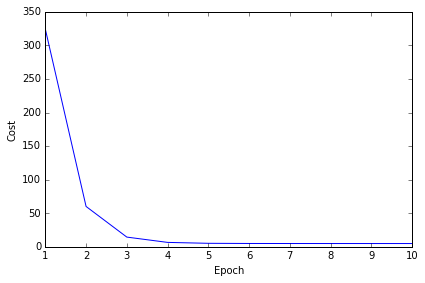

In [18]:
import matplotlib.pyplot as plt

costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
   
plt.plot(range(1, len(costs)+1), costs)

plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()
# plt.savefig('./figures/cost_convergence.png', dpi=300)
plt.show()

### Make prediction

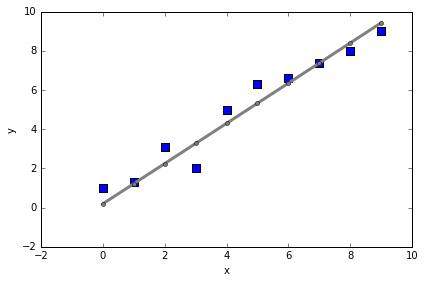

In [19]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    y_pred = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=y_pred)
    return predict(X)

plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), 
         predict_linreg(X_train, w), 
         color='gray', 
         marker='o', 
         markersize=4, 
         linewidth=3)

plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
# plt.savefig('./figures/linreg.png', dpi=300)
plt.show()

# Theano for neural networks

Also use Keras library

# Choosing activation functions for feedforward neural networks

There are various activation functions for a multi-layer neural networks.
* in theory we can use any differential function
* in practice we want (1) non-linearity and (2) goood convergence for gradient descent

Sigmoid is one we have seen.
* mimics biological neurons
* converge slowly for deep networks (vanishing gradients)

## Logistic function recap

The logistic function, often just called "sigmoid function" is in fact a special case of a sigmoid function.

Linear input $z$:
$$
\begin{align}
z &=  w_0x_{0} + \dots + w_mx_{m} 
\\
&= \sum_{j=0}^{m} x_{j}w_{j} 
\\ 
&= \mathbf{w}^T\mathbf{x}
\end{align}
$$
$w_0$ is the bias term, matching $x_0 = 1$

Logistic activation function:

$$\phi_{logistic}(z) = \frac{1}{1 +  e^{-z}}$$

Output range: (0, 1)
* probability for the positive class $z > 0$

### Concrete example

In [20]:
# note that first element (X[0] = 1) to denote bias unit

X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return np.asscalar(logistic(z))

print('P(y=1|x) = %.3f' % logistic_activation(X, w))

P(y=1|x) = 0.707


## Multiple outputs

One-hot encoding for multi-class classification.
* $K$ outputs for $K$ classes

Logistic activation outputs cannot be directly interpreted as probabilities.

### Example

A MLP perceptron with 
* 3 hidden units + 1 bias unit in the hidden unit 
* 3 output units

In [21]:
# W : array, shape = [n_output_units, n_hidden_units+1]
#          Weight matrix for hidden layer -> output layer.
# note that first column (A[:][0] = 1) are the bias units
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

# A : array, shape = [n_hidden+1, n_samples]
#          Activation of hidden layer.
# note that first element (A[0][0] = 1) is for the bias units

A = np.array([[1.0], 
              [0.1], 
              [0.3], 
              [0.7]])

# Z : array, shape = [n_output_units, n_samples]
#          Net input of output layer.

Z = W.dot(A) 
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


The outputs do not sum to 1 and thus are not probabilities.

Need normalization for probability
* divide all outputs by their summation
* softmax which should be applied to z (linear inputs) before logistic activation

OK for classification:

In [22]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


## Estimating probabilities in multi-class classification via the softmax function

The softmax function 
* is a generalization of the logistic function
* allows us to compute meaningful class probabilities in multi-class settings
* i.e. multinomial logistic regression

$z$: linear input as usual

$K$: number of classes

$$
\begin{align}
P(y=j|z) =\phi_{softmax}(z) = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}
\end{align}
$$

$P(y=j | z)$: probability of class $j$ for input $z$ in range $(0, 1)$ 

In [23]:
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

In [24]:
y_probas = softmax(Z) # same Z computed above
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


In [25]:
y_probas.sum()

1.0

The class probabilities sum to 1.

The predicted class is the same as logistic regression.

In [26]:
y_class = np.argmax(Z, axis=0)
y_class

array([2], dtype=int64)

## Broadening the output spectrum using a hyperbolic tangent

Another special case of a sigmoid function, it can be interpreted as a rescaled version of the logistic function.

$$
\begin{align}
\phi_{tanh}(z) = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}
\end{align}
$$

$\phi_{tanh}$ is a rescaled version of $\phi_{logistic}$:
$$
\begin{align}
\phi_{tanh}(z) = 2 \phi_{logistic}(z) - 1
\end{align}
$$

Output range: (-1, 1)

In [27]:
def tanh(z):
    e_p = np.exp(z) 
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)  

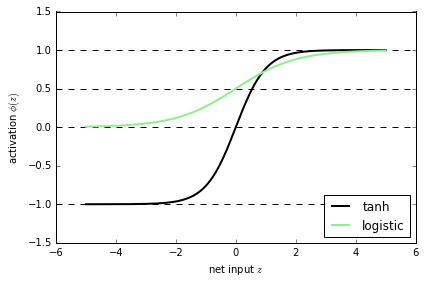

In [28]:
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

# alternatives:
# from scipy.special import expit
# log_act = expit(z)
# tanh_act = np.tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')

plt.plot(z, tanh_act, 
         linewidth=2, 
         color='black', 
         label='tanh')
plt.plot(z, log_act, 
         linewidth=2, 
         color='lightgreen', 
         label='logistic')

plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/activation.png', dpi=300)
plt.show()

## Different activation functions

<img src='./images/13_05.png' width=100%>

# Training neural networks efficiently using Keras

A library (stared in early 2015) to facilitate neural network training.
* built on top of Theano
* intuitive and popular API

Once you have Theano installed, [Keras](https://github.com/fchollet/keras) can be installed via

    pip install Keras

### Loading MNIST

1) Download the 4 MNIST datasets from http://yann.lecun.com/exdb/mnist/

- train-images-idx3-ubyte.gz:  training set images (9912422 bytes) 
- train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 
- t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) 
- t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

2) Unzip those files

3) Copy the unzipped files to a directory `./mnist`

Li-Yi: I enhanced the functions below so that we can do everything (including downloading and decompression) inside ipynb.

In [29]:
import os
import os.path
import struct
import gzip
import numpy as np
 
def open_mnist(full_path):
    if full_path.find('.gz') >= 0:
        return gzip.open(full_path, 'rb')
    else:
        return open(full_path, 'rb')
        
def pick_mnist(path, name, exts):
    for ext in exts:
        full_path = os.path.join(path, name + ext)
        if os.path.isfile(full_path):
            return full_path
    # none of the exts options works    
    return None

def load_mnist(path, kind='train', exts=['', '.gz']):
    """Load MNIST data from `path`"""
    labels_path = pick_mnist(path, kind + '-labels-idx1-ubyte', exts)
    images_path = pick_mnist(path, kind + '-images-idx3-ubyte', exts)
    
    with open_mnist(labels_path) as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))        
        if(magic != 2049):
            raise IOError(str(magic) + ' != ' + str(2049))
            
        # np.fromfile does not work with gzip open   
        # http://stackoverflow.com/questions/15966335/efficient-numpy-fromfile-on-zipped-files
        # labels = np.fromfile(lbpath, dtype=np.uint8)
        content = lbpath.read()    
        labels = np.frombuffer(content, dtype=np.uint8)
        if(len(labels) != n):
            raise IOError(str(len(labels)) + ' != ' + str(n))
        
    with open_mnist(images_path) as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        if(magic != 2051):
            raise IOError(str(magic) + ' != ' + str(2051))
            
        # images = np.fromfile(imgpath, dtype=np.uint8).reshape(num, rows*cols)
        content = imgpath.read()    
        images = np.frombuffer(content, dtype=np.uint8).reshape(num, rows*cols)
        if(num != len(labels)):
            raise IOError(str(num) + ' != ' + str(len(labels)))
            
    return images, labels

In [30]:
mnist_data_folder = os.path.join('..', 'datasets', 'mnist')
exts = ['', '.gz'] # for already gunzipped files and not yet gzipped files

X_train, y_train = load_mnist(mnist_data_folder, kind='train', exts=exts)
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist(mnist_data_folder, kind='t10k', exts=exts)
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


### Multi-layer Perceptron in Keras

In order to run the following code via GPU, you can execute the Python script that was placed in this directory via

    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python mnist_keras_mlp.py

In [31]:
import theano 

theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

#### One-hot encoding of the class variable

In [32]:
from keras.utils import np_utils

print('First 3 labels: ', y_train[:3])

y_train_ohe = np_utils.to_categorical(y_train) 
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


#### Implement a neural network

* fully connected with 2 hidden layers

* tanh for hidden layers

* softmax for output layer

* cross entropy loss function (to match softmax output)

* SGD optimization

In [33]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1) 

model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], 
                output_dim=50, 
                init='uniform', 
                activation='tanh'))

model.add(Dense(input_dim=50, 
                output_dim=50, 
                init='uniform', 
                activation='tanh'))

model.add(Dense(input_dim=50, 
                output_dim=y_train_ohe.shape[1], 
                init='uniform', 
                activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

model.fit(X_train, y_train_ohe, 
          nb_epoch=50, 
          batch_size=300, 
          verbose=1, 
          validation_split=0.1 # 10% of training data for validation per epoch
         )

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s - loss: 2.2290 - acc: 0.3593 - val_loss: 2.1094 - val_acc: 0.5343
Epoch 2/50
54000/54000 [==============================] - 2s - loss: 1.8846 - acc: 0.5302 - val_loss: 1.6060 - val_acc: 0.5582
Epoch 3/50
54000/54000 [==============================] - 3s - loss: 1.3895 - acc: 0.5913 - val_loss: 1.1680 - val_acc: 0.6757
Epoch 4/50
54000/54000 [==============================] - 2s - loss: 1.0596 - acc: 0.6944 - val_loss: 0.9003 - val_acc: 0.7732
Epoch 5/50
54000/54000 [==============================] - 3s - loss: 0.8551 - acc: 0.7725 - val_loss: 0.7276 - val_acc: 0.8312
Epoch 6/50
54000/54000 [==============================] - 3s - loss: 0.7184 - acc: 0.8174 - val_loss: 0.6157 - val_acc: 0.8593
Epoch 7/50
54000/54000 [==============================] - 3s - loss: 0.6256 - acc: 0.8457 - val_loss: 0.5373 - val_acc: 0.8797
Epoch 8/50
54000/54000 [==============================] - 2s -

In [34]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [35]:
train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

Training accuracy: 94.15%


In [36]:
y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

Test accuracy: 93.58%


# Summary

Plenty deep learning libraries to use so that we do not have to write code from scratch.
* TensorFlow: similar flavor to Theano, developed by Google
* Torch7: via lua language, used by DeepMind folks and Yann LeCun
* Caffe: c++ library
* etc.

Alternative libraries with Theano:
* Pylearn2
* Lasagne: more minimalistic and extensible

# Reading

* PML Chapter 13